<a href="https://colab.research.google.com/github/HakureiPOI/Modeling_Allowance/blob/main/GSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class GravitationalSearchAlgorithm:
    def __init__(self, obj_function, dim, bounds, num_agents=256, max_iter=100, g0=0.8, alpha=2, minimize=True):
        """
        初始化引力搜索算法（GSA）

        参数：
        - obj_function: 目标函数，需要最小化
        - dim: 问题的维度。
        - bounds: 每个维度的边界，格式为 [(lower_bound1, upper_bound1), ...]。
        - num_agents: 粒子（解）的数量
        - max_iter: 最大迭代次数
        - g0: 初始引力常数
        - alpha: 引力常数的动态调整参数，控制其衰减速度
        - minimize: 是否最小化目标函数（默认为True）
        """
        self.obj_function = obj_function
        self.dim = dim
        self.bounds = bounds
        self.num_agents = num_agents
        self.max_iter = max_iter
        self.g0 = g0
        self.alpha = alpha
        self.minimize = minimize

        # 设置随机数种子
        np.random.seed(42)

        # 初始化粒子的位置和速度
        self.positions = np.random.uniform(0, 1, (num_agents, dim))
        for i in range(dim):
            lower, upper = bounds[i]
            self.positions[:, i] = lower + self.positions[:, i] * (upper - lower)
        self.velocities = np.zeros((num_agents, dim))
        self.best_position = None
        self.best_score = float('inf')
        self.history = []

    def _evaluate_fitness(self):
        """评估每个粒子的适应度（目标函数值）"""
        fitness = np.array([self.obj_function(pos) for pos in self.positions])
        return fitness if self.minimize else -fitness

    def _update_gravitational_constant(self, iteration):
        """动态调整引力常数，使得最后能缓慢收敛"""
        return self.g0 * (1 - iteration / self.max_iter) ** self.alpha

    def _calculate_masses(self, fitness):
        """根据适应度计算每个粒子的质量，适配最小化问题"""
        worst = max(fitness)
        best = min(fitness)
        if best == worst:
            masses = np.ones_like(fitness)
        else:
            # 使用反向差值
            masses = (worst - fitness) / (worst - best + 1e-10)
        return masses / masses.sum()

    def _calculate_forces(self, masses, g):
        """矢量化计算作用在每个粒子上的引力"""
        forces = np.zeros((self.num_agents, self.dim))
        for i in range(self.num_agents):
            distances = np.linalg.norm(self.positions - self.positions[i], axis=1) + 1e-10
            directions = self.positions - self.positions[i]
            forces[i] = np.sum(
                g * masses[i] * masses[:, np.newaxis] / distances[:, np.newaxis] * directions,
                axis=0
            )
        return forces

    def _update_positions_and_velocities(self, forces, masses):
        """更新粒子的位置和速度"""
        accelerations = forces / (masses[:, np.newaxis] + 1e-10)
        self.velocities = np.random.rand(self.num_agents, self.dim) * self.velocities + accelerations
        self.positions += self.velocities

        # 应用边界约束
        for i in range(self.dim):
            lower, upper = self.bounds[i]
            self.positions[:, i] = np.clip(self.positions[:, i], lower, upper)

    def optimize(self):
        """运行优化过程"""
        for iteration in range(self.max_iter):
            # 第一步：评估适应度
            fitness = self._evaluate_fitness()

            # 更新全局最优解
            best_fitness_idx = np.argmin(fitness)
            if fitness[best_fitness_idx] < self.best_score:
                self.best_score = fitness[best_fitness_idx]
                self.best_position = self.positions[best_fitness_idx].copy()

            self.history.append(self.best_score)

            # 检测提前收敛条件
            if iteration > 0 and abs(self.history[-1] - self.history[-2]) < 1e-10:
                print(f"优化在第 {iteration + 1} 代提前收敛，当前最优适应度: {self.best_score}")
                break

            # 第二步：更新引力常数
            g = self._update_gravitational_constant(iteration)

            # 第三步：计算质量
            masses = self._calculate_masses(fitness)

            # 第四步：计算引力
            forces = self._calculate_forces(masses, g)

            # 第五步：更新位置和速度
            self._update_positions_and_velocities(forces, masses)

            print(f"第 {iteration + 1}/{self.max_iter} 代, 当前最优适应度: {self.best_score}")

        return self.best_position, self.best_score

    def plot_optimization_history(self):
        sns.set(style="whitegrid")
        plt.figure(figsize=(10, 6))
        plt.plot(self.history, label="Best Fitness", color="b")
        plt.xlabel("Iteration")
        plt.ylabel("Best Fitness")
        plt.title("Optimization History")
        plt.legend()
        plt.show()

In [3]:
def complex_function(x):
    # x 是目标函数的变量列表
    return sum((1 - x[:-1])**2 + 100 * (x[1:] - x[:-1]**2)**2)

In [4]:
dim = 100
bounds = [(-5, 5)] * dim  # 每个维度不同的边界
gsa = GravitationalSearchAlgorithm(obj_function=complex_function, dim=dim, bounds=bounds)
best_position, best_score = gsa.optimize()

第 1/100 代, 当前最优适应度: 836178.1904805666
第 2/100 代, 当前最优适应度: 771881.7623914114
第 3/100 代, 当前最优适应度: 684979.7145502747
第 4/100 代, 当前最优适应度: 597858.8047229395
第 5/100 代, 当前最优适应度: 516778.27014643775
第 6/100 代, 当前最优适应度: 434147.3021783245
第 7/100 代, 当前最优适应度: 363415.04914086673
第 8/100 代, 当前最优适应度: 300633.5440249789
第 9/100 代, 当前最优适应度: 247817.3526847561
第 10/100 代, 当前最优适应度: 201253.99516381836
第 11/100 代, 当前最优适应度: 166373.2832556872
第 12/100 代, 当前最优适应度: 136620.98575933347
第 13/100 代, 当前最优适应度: 111563.4645500437
第 14/100 代, 当前最优适应度: 91901.12348809994
第 15/100 代, 当前最优适应度: 75348.12681621964
第 16/100 代, 当前最优适应度: 62025.58134055436
第 17/100 代, 当前最优适应度: 51415.19655241362
第 18/100 代, 当前最优适应度: 42467.44029330659
第 19/100 代, 当前最优适应度: 34316.6783782104
第 20/100 代, 当前最优适应度: 27252.476752505794
第 21/100 代, 当前最优适应度: 21797.843742708672
第 22/100 代, 当前最优适应度: 17297.321663391296
第 23/100 代, 当前最优适应度: 13620.673171804992
第 24/100 代, 当前最优适应度: 10614.537139542543
第 25/100 代, 当前最优适应度: 8110.800124350873
第 26/100 代, 当前最优适应度: 6433.

In [5]:
print(f"最优位置: {best_position}")
print(f"最优适应度: {best_score}")

最优位置: [-0.17867138 -0.2172415  -0.03337283  0.08201512  0.10283507  0.03118442
  0.39740843  0.15672807 -0.03940298 -0.21039698 -0.20038089  0.06312175
  0.08912181 -0.33069063 -0.08599868 -0.08887375 -0.34606862  0.31088287
  0.14188375 -0.01979767  0.13434377  0.00102355  0.18547366  0.33492305
 -0.15805657  0.02667346 -0.24171419 -0.07138832  0.08293572 -0.05189994
  0.03917129 -0.04813614 -0.0769475   0.09749632 -0.17278378  0.0330873
  0.05620072  0.08982559  0.06522562  0.02205527  0.34267545 -0.13576139
  0.09544323  0.4036779  -0.08883588  0.14535749  0.02354019 -0.09173393
  0.35337246 -0.10774912 -0.00206434 -0.05410228 -0.03748039  0.27744966
  0.16392673  0.15211598 -0.14147583 -0.00741918 -0.10526124  0.19889963
 -0.02507087 -0.0954137   0.25121721 -0.11247663  0.25812597 -0.06905781
 -0.04608051 -0.15673038  0.14400166 -0.23521978 -0.25261578  0.30521134
 -0.34356184  0.02993614  0.3820931   0.12990094 -0.21321932  0.06818423
  0.09061153 -0.25059113 -0.07974932  0.095778

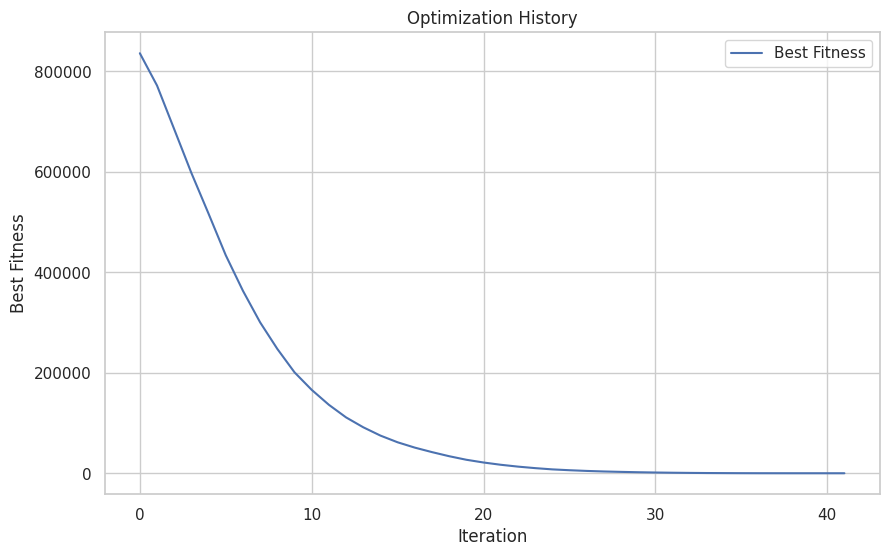

In [6]:
gsa.plot_optimization_history()